In [1]:
import sysconfig
import os
import numpy as np
import pandas as pd
import json
import distutils
import scrapy
import requests
import json
import logging
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
# Read the data file and display
train = pd.read_json('WebData/stayz_nsw_extract_2018-02-17_22-59.json')

train.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_id,property_type,scraped_date,url
0,2,4,8,Rakali Cottage features deep water lake fronta...,8,Rakali Cottage Lake Conjola,195,-35.267900,150.48200,9119008,House,2018-02-17 22:59:18,https://www.stayz.com.au//accommodation/nsw/so...
1,1,2,5,Lola's Loft is a self contained house with lov...,5,Top Of The Range Jindabyne,143,-36.521973,148.69348,9110247,House,2018-02-17 22:59:18,https://www.stayz.com.au//accommodation/nsw/sn...
2,2,4,6,Darryl Kerrigan proclaimed in the classic Aust...,9,THE PALMS At Erowal Bay Pet Friendly,170,-35.098663,150.65290,9094119,House,2018-02-17 22:59:18,https://www.stayz.com.au//accommodation/nsw/so...
3,3,7,15,Secrets of Terara is an enchanted getaway just...,18,Secrets of Terara -Enchanted Getaway,808,-34.884420,150.63110,9181518,House,2018-02-17 22:59:18,https://www.stayz.com.au//accommodation/nsw/so...
4,2,2,2,Sydney’s ultimate harbourside lifestyle awaits...,4,Sydney Darling Harbour Luxury 2 Br Apartment,405,-33.870354,151.19789,9162472,Apartment,2018-02-17 22:59:18,https://www.stayz.com.au//accommodation/nsw/sy...


In [63]:
# If the initial price is zero, set to NaN so it doesnt affect the statistics
train.loc[train['init_price'] == 0,'init_price'] = np.nan

train.describe()


,bathrooms,bedrooms,beds,guests,init_price,lat,lng,property_id
count,18328.000000,18328.000000,18328.000000,18328.000000,17766.000000,18328.000000,18328.000000,1.832800e+04
mean,1.848265,2.974411,4.323821,6.681362,312.845548,-33.166157,151.283910,1.741173e+06
std,1.151460,1.564827,3.162374,3.782263,2360.292605,2.578310,4.671677,3.370177e+06
min,0.000000,0.000000,0.000000,1.000000,1.000000,-41.449306,-100.945830,3.000000e+01
25%,1.000000,2.000000,3.000000,4.000000,141.000000,-34.771686,150.557215,1.310150e+05
50%,2.000000,3.000000,4.000000,6.000000,205.000000,-33.598714,151.275680,1.925720e+05
75%,2.000000,4.000000,5.000000,8.000000,327.000000,-32.346868,152.184393,2.247738e+05
max,41.000000,41.000000,100.000000,120.000000,312197.000000,45.466415,167.949000,9.228610e+06


In [64]:
train_s1 = train.loc[train['guests'] <= 4]

train_s2 = train_s1.loc[train_s1['bathrooms'] <= 4 ]

train_small = train_s2.loc[train_s2['beds'] <= 6 ]


train_small.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_id,property_type,scraped_date,url
4,2,2,2,Sydney’s ultimate harbourside lifestyle awaits...,4,Sydney Darling Harbour Luxury 2 Br Apartment,405.0,-33.870354,151.19789,9162472,Apartment,2018-02-17 22:59:18,https://www.stayz.com.au//accommodation/nsw/sy...
15,1,1,1,BOUTIQUE 5 STAR STUDIO,2,Cat On The Hat Cottage ~MeOw MeOw~,110.0,-33.631090,150.28883,9148849,Studio,2018-02-17 22:59:19,https://www.stayz.com.au//accommodation/nsw/bl...
19,1,2,2,"Contemporary, interior-designed coastal retrea...",4,Retro Beach House at Pearl Beach,305.0,-33.538840,151.30493,9208820,House,2018-02-17 22:59:20,https://www.stayz.com.au//accommodation/nsw/ce...
20,2,2,4,Our 4 cottages are set in a glorious bushland ...,4,TOUCHDOWN COTTAGES JINDABYNE,128.0,-36.428400,148.60300,9060812,Cottage,2018-02-17 22:59:20,https://www.stayz.com.au//accommodation/nsw/sn...
22,2,1,1,KINDLY NO CHILDREN OR PETS PLEASE,2,Sails On The Bay-Absolute Waterfront Property,260.0,-35.070300,150.67800,9077038,Apartment,2018-02-17 22:59:20,https://www.stayz.com.au//accommodation/nsw/so...


In [69]:
# Testing - look in detail at any outliers

t1 = train_small.loc[train_small['init_price'] == 2200]
t1.head()

,bathrooms,bedrooms,beds,description_full,guests,heading,init_price,lat,lng,property_id,property_type,scraped_date,url
7353,2,3,3,"Contemporary Hotels presents, The Coogee. A th...",4,THE COOGEE,2200.0,-33.923473,151.24829,176951,House,2018-02-17 23:09:07,https://www.stayz.com.au//accommodation/nsw/sy...


In [70]:
train_small.describe()


,bathrooms,bedrooms,beds,guests,init_price,lat,lng,property_id
count,4819.000000,4819.000000,4819.000000,4819.000000,4682.000000,4819.000000,4819.000000,4.819000e+03
mean,1.191741,1.603860,2.106246,3.348828,185.596754,-32.972912,151.069342,2.096677e+06
std,0.420231,0.561082,0.919283,0.901387,108.871403,3.272563,8.021186,3.621929e+06
min,0.000000,0.000000,0.000000,1.000000,14.000000,-37.149223,-84.997270,7.470000e+02
25%,1.000000,1.000000,1.000000,2.000000,122.000000,-34.180645,150.656720,1.406090e+05
50%,1.000000,2.000000,2.000000,4.000000,168.000000,-33.711790,151.251950,1.983600e+05
75%,1.000000,2.000000,3.000000,4.000000,224.000000,-32.179199,152.500900,2.277400e+05
max,4.000000,6.000000,6.000000,4.000000,2200.000000,45.466415,153.635880,9.228590e+06


In [83]:
bin_values = np.arange(start=0, stop=600, step=10)

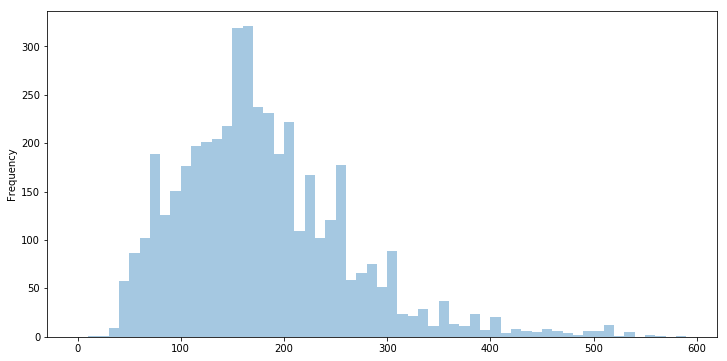

In [87]:
tran_small_price1 = train_small.loc[train_small['bedrooms'] <= 2]
                                    
tran_small_price = tran_small_price1['init_price']

tran_small_price.plot(kind='hist', bins=bin_values, figsize=[12,6], alpha=.4) # alpha for transparency

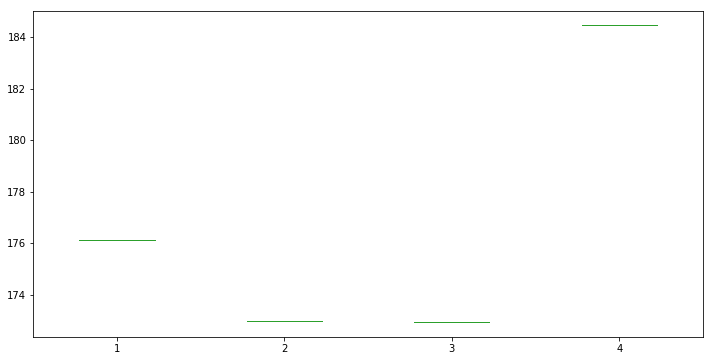

In [62]:
ts1 = train_small.pivot_table(columns='guests', values='init_price')
ts1.plot(kind='box', figsize=[12,6], legend=True) # alpha for transparency


In [46]:
ts1.describe()

guests,1,2,3,4
count,1.000000,1.000000,1.000000,1.000000
mean,176.111111,172.979754,172.950725,184.451655
std,NaN,NaN,NaN,NaN
min,176.111111,172.979754,172.950725,184.451655
25%,176.111111,172.979754,172.950725,184.451655
50%,176.111111,172.979754,172.950725,184.451655
75%,176.111111,172.979754,172.950725,184.451655
max,176.111111,172.979754,172.950725,184.451655


Text(0,0.5,'Count')

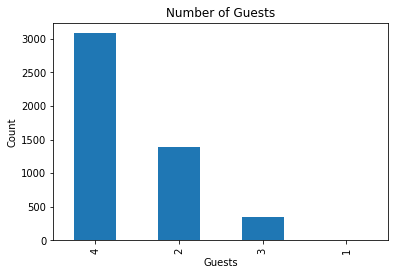

In [49]:
train_small['guests'].value_counts().plot(kind='bar')
plt.title('Number of Guests')
plt.xlabel('Guests')
plt.ylabel('Count')

In [10]:
train_small['guests'].groupby(train_small['guests']).count()

guests
1       9
2    1383
3     345
4    3082
Name: guests, dtype: int64

In [11]:
train_display = pd.DataFrame({
    #'Nbr Reviews': train_small['reviews'],
    'Price': train_small['init_price'],
    'Type': train_small['property_type'],
    'Bathrooms' : train_small['bathrooms'],
    'Beds' : train_small['beds']
})


#train_display.groupby('Type').hist()

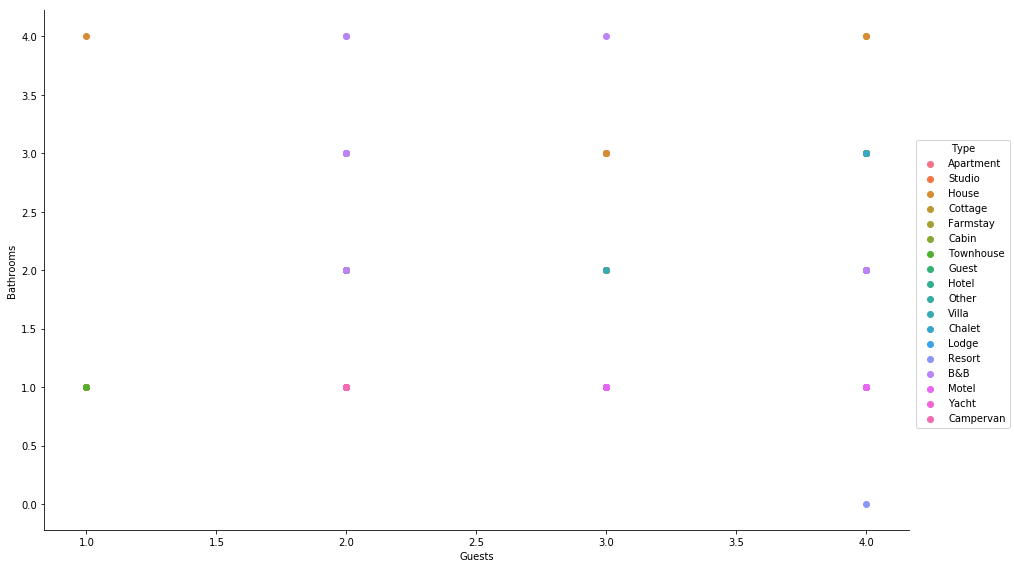

In [12]:
df = pd.DataFrame({
    'Guests': train_small['guests'],
    'Bathrooms': train_small['bathrooms'],
    'Type': train_small['property_type']
})

fg = sns.FacetGrid(data=df, hue='Type', aspect=1.61, size=8)
fg.map(plt.scatter, 'Guests', 'Bathrooms').add_legend()

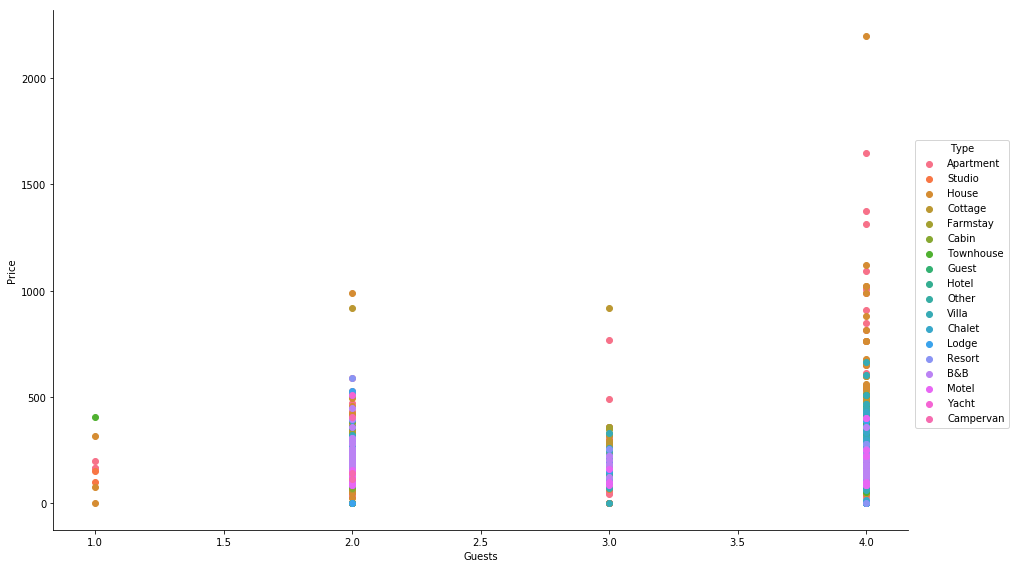

In [13]:
df = pd.DataFrame({
    'Guests': train_small['guests'],
    'Price': train_small['init_price'],
    'Type': train_small['property_type']
})

fg = sns.FacetGrid(data=df, hue='Type', aspect=1.61, size=8)
fg.map(plt.scatter, 'Guests', 'Price').add_legend()

In [14]:
#df = pd.DataFrame({
    #'Nbr Reviews': train_small['reviews'],
#    'Price': train_small['init_price'],
#    'Type': train_small['property_type'],    
#})

#fg = sns.FacetGrid( data=df, hue='Type', aspect=1.61, size=10)
#fg.map(plt.scatter, 'Type', 'Price').add_legend()

In [15]:
#X = train.drop(['init_price'],axis=1)
#X = X.drop(['lat'],axis=1)
#X = X.drop([''],axis=1)

X = pd.DataFrame({
    #'Nbr Reviews': train_small['reviews'],
    'Price': train_small['init_price'],
    #'Type': train['property_type'],
    'Bathrooms' : train_small['bathrooms'],
    'Beds' : train_small['beds'],
    'Guests' : train_small['guests'],
    'Lat' : train_small['lat'],
    'Lon' : train_small['lng']
})
Y = train_small['init_price']

In [16]:
X.describe()

,Bathrooms,Beds,Guests,Lat,Lon,Price
count,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000
mean,1.191741,2.106246,3.348828,-32.972912,151.069342,180.320398
std,0.420231,0.919283,0.901387,3.272563,8.021186,111.658293
min,0.000000,0.000000,1.000000,-37.149223,-84.997270,0.000000
25%,1.000000,1.000000,2.000000,-34.180645,150.656720,116.500000
50%,1.000000,2.000000,4.000000,-33.711790,151.251950,165.000000
75%,1.000000,3.000000,4.000000,-32.179199,152.500900,224.000000
max,4.000000,6.000000,4.000000,45.466415,153.635880,2200.000000


In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4819 entries, 4 to 18327
Data columns (total 6 columns):
Bathrooms    4819 non-null int64
Beds         4819 non-null int64
Guests       4819 non-null int64
Lat          4819 non-null float64
Lon          4819 non-null float64
Price        4819 non-null int64
dtypes: float64(2), int64(4)
memory usage: 423.5 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116be5198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116f6c128>]], dtype=object)

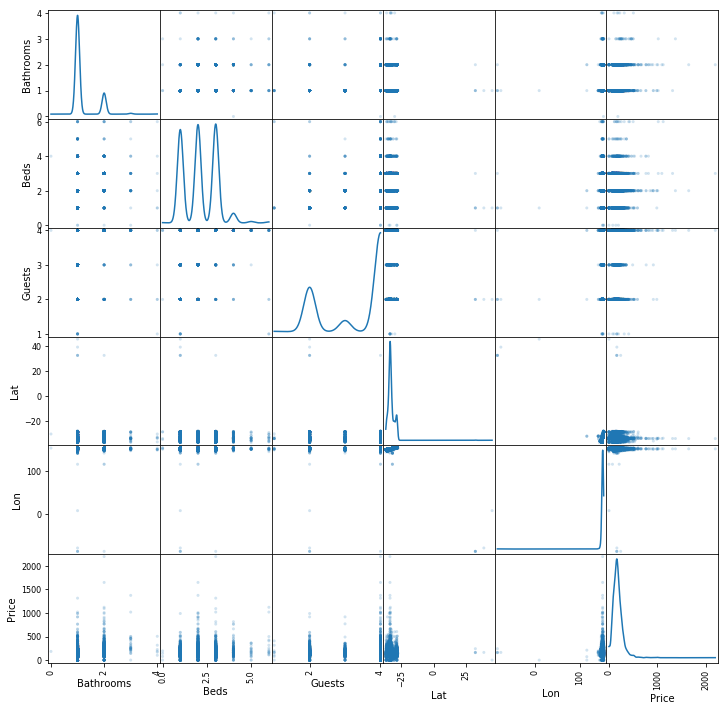

In [18]:
from pandas.plotting import scatter_matrix
scatter_matrix(X, alpha=0.2, figsize=(12, 12), diagonal='kde')

In [19]:
model = DecisionTreeClassifier()
model.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:

print(cross_val_score(model,X,Y,cv=10,scoring='accuracy').mean())

/Users/taj/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0.975700401881
